In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = 11,5

In [2]:
# мои данные по продажам курсов бю Аналитики Нетологии (с того момента, как я устроился сюда работать, то есть с 01.04.20)
df = pd.read_csv('amocrm_export_leads_2021-08-07.csv', sep=',', low_memory = 'false')

C:\Users\Asus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (21,26,29,34,51,58,61,69,71,73,74,75,76,77,80,84,87,88,93,94,98,110,111,112) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
selected_df = df[['Бюджет ', 'Дата создания сделки', 'Дата закрытия', 'Причина отказа', 'Этап сделки', 
                  'URL-group *', 'физ\\ юр', 'Дата старта *']]

In [5]:
# редактирую датафрейм (там куча всяких моментов есть, но в учебных целях думаю этого достаточно)


# сначала удаляю строки без указания курса и даты старта (это не критично, возможно тестовые курсы или еще что)
selected_df = selected_df[selected_df['URL-group *'].notna()]
selected_df = selected_df[selected_df['Дата старта *'].notna()]

# если происходит автооплата, менеджер не успевает указать физ. или юр., но автооплата возможно только от физ. лиц
selected_df['физ\ юр'].fillna('физ лицо', inplace=True)

# привожу коды курсов к общему регистру
selected_df['URL-group *'] = selected_df['URL-group *'].str.lower()

# закрыть сделку не указав причинку отказа нельзя, соотв. без причины отказа только успешные сделки
selected_df['Причина отказа'].fillna('Курс куплен', inplace=True)

# делаю более удобное время
selected_df['Дата создания сделки'] = pd.to_datetime(selected_df['Дата создания сделки'],errors="coerce").dt.strftime('%d-%m-%Y')
selected_df['Дата закрытия'] = pd.to_datetime(selected_df['Дата закрытия'],errors="coerce").dt.strftime('%d-%m-%Y')

# перевожу в формат datetime
selected_df['Дата создания сделки'] = selected_df['Дата создания сделки'].astype('datetime64')
selected_df['Дата закрытия'] = selected_df['Дата закрытия'].astype('datetime64')
selected_df['Дата старта *'] = selected_df['Дата старта *'].astype('datetime64')


#ввожу столбик длина сделки
selected_df['Длина сделки'] = selected_df['Дата закрытия'] - selected_df['Дата создания сделки']
selected_df['Длина сделки'] = selected_df['Длина сделки'].astype('int64') / 86400000000000 # в числовом формате
selected_df['Длина сделки'] = selected_df['Длина сделки'].astype('int64') 

# Этап сделки меняю на числовой формат


#для удобства меняю местами столбцы с длиной сделки
cols = selected_df.columns.tolist()
cols = ['Бюджет ',
 'Дата создания сделки',
 'Дата закрытия','Длина сделки',
 'Причина отказа',
 'Этап сделки',
 'URL-group *',
 'физ\\ юр',
 'Дата старта *']

selected_df = selected_df[cols]

<ipython-input-5-4229002998bb>:29: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  selected_df['Длина сделки'] = selected_df['Длина сделки'].astype('int64') / 86400000000000 # в числовом формате


In [17]:
selected_df.head()

,Бюджет,Дата создания сделки,Дата закрытия,Длина сделки,Причина отказа,Этап сделки,URL-group *,физ\ юр,Дата старта *
0,96000,2021-08-06,2021-08-06,0,Курс куплен,Успешно реализовано,dau,физ лицо,2021-08-18
1,126000,2021-08-06,2021-08-06,0,Выбирает на будущее. Учиться сейчас не планирует,Закрыто и не реализовано,ds,физ лицо,2021-08-13
2,86400,2021-08-05,2021-08-05,0,Курс куплен,Успешно реализовано,dau,физ лицо,2021-08-18
3,60000,2021-08-05,2021-08-05,0,Выбирает на будущее. Учиться сейчас не планирует,Закрыто и не реализовано,abi,физ лицо,2021-08-13
4,9000,2021-08-05,2021-08-05,0,Нужна другая программа,Закрыто и не реализовано,dfd,физ лицо,2021-08-16


In [8]:
# сколько денег я получал ежедневно

filtered_df_1 = selected_df[(selected_df['Этап сделки'] == 'Успешно реализовано')]
leads_by_day = filtered_df_1[['Бюджет ', 'Дата создания сделки']].groupby('Дата создания сделки').sum()
leads_by_day

,Бюджет
Дата создания сделки,
2020-04-01,80440
2020-04-02,75030
2020-04-03,185805
2020-04-04,285709
2020-04-05,214800
...,...
2021-08-02,296400
2021-08-03,462000
2021-08-04,208200


Text(0, 0.5, 'Сумма продаж, тыс.')

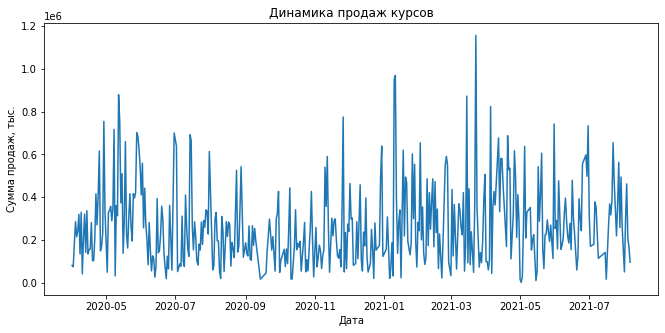

In [9]:
# ничего полезного не вижу, тестовый график, разве что из-за введения дорогих курсов разброс стал выше

plt.plot(leads_by_day.index, leads_by_day['Бюджет '])
plt.title('Динамика продаж курсов')
plt.xlabel('Дата')
plt.ylabel('Сумма продаж, тыс.')

In [10]:
# Хочу посмотреть динамику продаж с февраля (когда мы запустили все основные курсы)


filtered_df_4 = selected_df[(selected_df['Этап сделки'] == 'Успешно реализовано') & (selected_df['Дата создания сделки'] >= '2021-02-01')]
dynamics_by_sales = filtered_df_4[['Бюджет ', 'Дата закрытия']].groupby('Дата закрытия').sum()
dynamics_by_sales

,Бюджет
Дата закрытия,
2021-02-01,151500
2021-02-02,192000
2021-02-03,240230
2021-02-04,228500
2021-02-05,193145
...,...
2021-08-02,353025
2021-08-03,224400
2021-08-04,358200


Text(0, 0.5, 'Сумма продаж, тыс.')

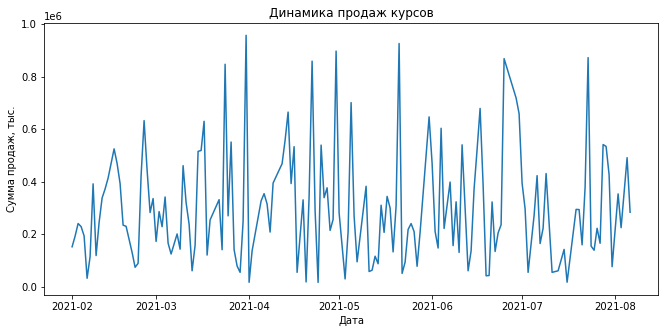

In [11]:
plt.plot(dynamics_by_sales.index, dynamics_by_sales['Бюджет '])
plt.title('Динамика продаж курсов')
plt.xlabel('Дата')
plt.ylabel('Сумма продаж, тыс.')

# Первый инсайт 

In [ ]:
#у продвинутого data scientist намного больше оплат, чем у обычного, когда у других флагманов равное распределение.

In [30]:
# какие курсы сколько денег принесли с 1 февраля 21 года
filtered_df_2 = selected_df[(selected_df['Дата создания сделки'] >= '2021-02-01')]
top_courses = filtered_df_2[['URL-group *', 'Бюджет ']].groupby('URL-group *').sum().sort_values('Бюджет ', ascending=False)
top_courses.head(7)

,Бюджет
URL-group *,
dsu,35184279
sal,15218200
da,11850922
dau,11619800
ds,8140900
abi,5691950
abu,4949700


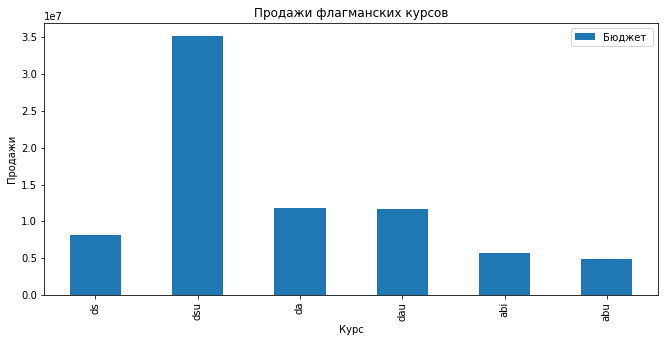

In [13]:
#хочу сравнить распределение денег от продажи курсов, где есть 'junior' и 'middle' уровни
"""data scientist с нуля до мидл - самый продаваемый курс, но интересно то, 
что другие программы поровну распределены между обычным курсом и мидл
"""
top_courses.loc[['ds', 'dsu', 'da', 'dau', 'abi', 'abu']].plot(kind='bar', 
                                                                  title='Продажи флагманских курсов',
                                                                  xlabel='Курс',
                                                                  ylabel='Продажи')

# Второй инсайт

In [ ]:
"""у программ уровня мидл средняя длина сделки ниже, чем у обычных курсов, тоже много пищи для размышлений, 
более дорогие, длинные и 'престижные' курсы берут быстрее"""

<ipython-input-38-735297e09ab0>:10: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  remove_outliers = selected_df[selected_df['Длина сделки'].between(lower_bound, upper_bound, inclusive=True)].sort_values('Длина сделки')


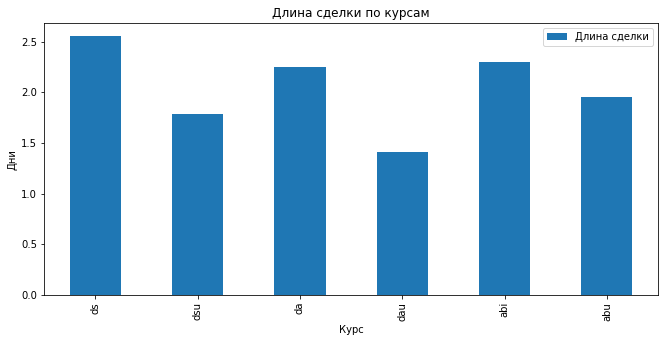

In [38]:
# Хочу посмотреть зависимость длины сделки от курса

#сначала избавляюсь от выбросов в длине сделки (на основании своей экспертизы говорю, что так можно)

q1 = selected_df['Длина сделки'].quantile(0.25)
q3 = selected_df['Длина сделки'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr) 
upper_bound = q3 + (1.5 * iqr)
remove_outliers = selected_df[selected_df['Длина сделки'].between(lower_bound, upper_bound, inclusive=True)].sort_values('Длина сделки')
remove_outliers

# фильтруем только по физикам для чистоты эксперимента, которые купили курс

filtered_df_5 = remove_outliers[(remove_outliers['Этап сделки'] == 'Успешно реализовано') & 
                                (remove_outliers['физ\ юр'] == 'физ лицо')]
filtered_df_5 = filtered_df_5.sort_values('Дата создания сделки', ascending=False)

#

new_df = filtered_df_5[['URL-group *', 'Длина сделки']].groupby('URL-group *').mean()

new_df.loc[['ds', 'dsu', 'da', 'dau', 'abi', 'abu']].plot(kind='bar', 
                                                                title='Длина сделки по курсам',
                                                                xlabel='Курс',
                                                                ylabel='Дни')

# Третий инсайт

In [ ]:
"""очень много людей отваливаются, не сказав, почему, значит маркетингу необходимо 
лучше доносить ценности, пересмотреть позиционирование и т.д., чтобы привлекать целевые лиды"""

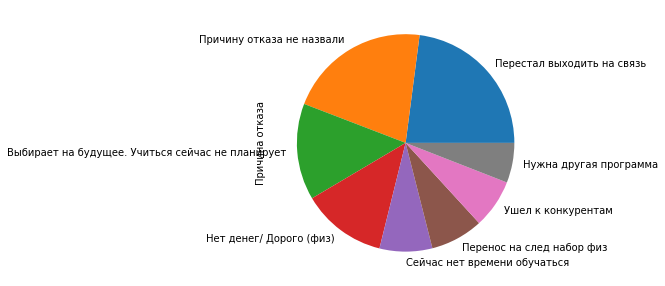

In [51]:
filtered_df_3 = selected_df[(selected_df['Этап сделки'] == 'Закрыто и не реализовано') & (selected_df['Дата создания сделки'] >= '2021-02-01')]
top_rejections = filtered_df_3['Причина отказа'].value_counts().head(8)         
top_rejections.plot(kind='pie')
#plt.legend()

# Четвертый инсайт

In [ ]:
"""чем выше стоимость курса - тем меньше длина сделки.
очень много всего можно из этого выделить"""

In [82]:
#ввожу столбик Оплата зарнее - за сколько дней до старта курса произведена оплата
selected_df['Оплата зарнее'] = selected_df['Дата старта *'] - selected_df['Дата закрытия']
selected_df['Оплата зарнее'] = selected_df['Оплата зарнее'].view('int64') / 86400000000000
#selected_df['Оплата зарнее'] = selected_df['Оплата зарнее'].view('int64') 

In [83]:
selected_df.head()

,Бюджет,Дата создания сделки,Дата закрытия,Длина сделки,Причина отказа,Этап сделки,URL-group *,физ\ юр,Дата старта *,Оплата зарнее
0,96000,2021-08-06,2021-08-06,0,Курс куплен,Успешно реализовано,dau,физ лицо,2021-08-18,12.0
1,126000,2021-08-06,2021-08-06,0,Выбирает на будущее. Учиться сейчас не планирует,Закрыто и не реализовано,ds,физ лицо,2021-08-13,7.0
2,86400,2021-08-05,2021-08-05,0,Курс куплен,Успешно реализовано,dau,физ лицо,2021-08-18,13.0
3,60000,2021-08-05,2021-08-05,0,Выбирает на будущее. Учиться сейчас не планирует,Закрыто и не реализовано,abi,физ лицо,2021-08-13,8.0
4,9000,2021-08-05,2021-08-05,0,Нужна другая программа,Закрыто и не реализовано,dfd,физ лицо,2021-08-16,11.0


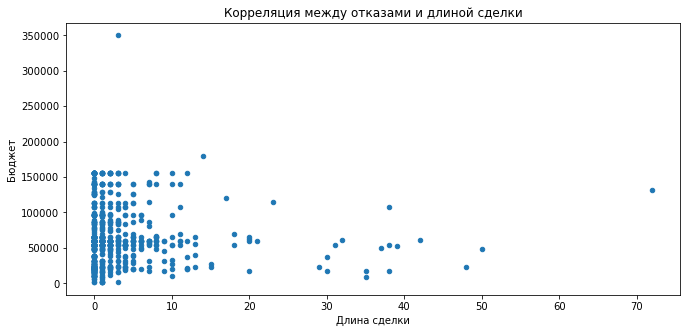

In [98]:
filtered_df_4 = selected_df[(selected_df['Этап сделки'] == 'Успешно реализовано') & (selected_df['Дата создания сделки'] >= '2021-02-01') & (selected_df['физ\ юр'] >= 'физ лицо')]

filtered_df_4.plot(kind='scatter', 
        x='Длина сделки', 
        y='Бюджет ', 
        title='Корреляция между отказами и длиной сделки')